Some questions we might ask are: 
1. What were the fastest and slowest growing population centers in the US? (done)
2. How does population density one census affect the rate of population growth the next decade, if at all? (done)
3. To what extent do regions mirror one another in population growth, as opposed to diverging from one another? 
4. What are the best and worse states in terms of people per representative? (done)
5. What is the spread of people per representative across states, and how has this changed over time? (done)
6. Fraction of representatives should correlate with fraction of population, right? (done) -- yes

Pop_change notes: 
CHANGE EXPRESSED AS PERCENTAGE (0-100).

Pop_density notes: 
DENSITY EXPRESSED AS PEOPLE PER SQUARE MILE.
DENSITY RANKING EXPRESSED IN ORDER OF MOST DENSE (1) TO LEAST DENSE (52).

Interesting observations: 
1. DC was the most dense from every census through 1910
2. The number of house seats was 433 in 1910, 1920, and then 435 from 1930 onwards. 
3. The worst-represented places aren't big states, but small ones like Rhode Island

## Setting Up

I'm going to import and clean up the data here.

In [46]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
% matplotlib inline
import matplotlib.pyplot as plt 

'''The population of each state at each decade, as well as the change from previous decade. 
X_POPULATION and X_CHANGE are the column names (X referring to a year ending with 10). 
There are these data for United States, Northeast, Midwest, South, West, 
Puerto Rico, and each individual state'''
pop_change_df = pd.read_csv('data/pop_change.csv', index_col=0, header=0, thousands=',')
pop_change_df.apply(pd.to_numeric)

'''The population density of each state. X_POPULATION, X_DENSITY, X_RANK are the keys'''
pop_density_df = pd.read_csv('data/pop_density.csv', index_col=0, header=0, skiprows=3, thousands=',')
pop_density_df.apply(pd.to_numeric)


'''The apportionment of representatives to the House by state. Keys include X_REPS,
X_PEOPLE_PER_REP, X_'''
apportionment_df = pd.read_csv('data/apportionment.csv', index_col=0, header=0, skiprows=1)
apportionment_df.apply(pd.to_numeric)
fix_nan_short = lambda num_or_nan: 0 if math.isnan(num_or_nan) else num_or_nan
apportionment_df = apportionment_df.applymap(fix_nan_short)

'''For some reason, 1920 people per rep is a column of zeroes. We can fix that here by just calculating it.'''
apportionment_df['1920_PEOPLE_PER_REP'] = pop_change_df['1920_POPULATION']/apportionment_df['1920_REPS']
fix_inf = lambda num_or_inf: math.nan if math.isinf(num_or_inf) else num_or_inf #this definitely works 
apportionment_df['1920_PEOPLE_PER_REP'] = apportionment_df['1920_PEOPLE_PER_REP'].apply(fix_inf)

'''The dataframes, but only with states.'''
states_pop_change = pop_change_df.iloc[range(5, len(pop_change_df))]
states_pop_density = pop_density_df.iloc[range(1, len(pop_density_df))]
state_apportionment = apportionment_df.iloc[range(1, len(apportionment_df))]

'''Takes in a function which itself reads an integer value of a valid year ending in 10. 
Valid years are 1910, 1920, ..., 2010. Returns a dictionary whose keys are years and 
values are func(year) for those years all of these years.'''
def values_for_all_years(func): 
    return_dict = {}
    for i in range(11): 
        return_dict[1910 + (10 * i)] = func(1910 + (10 * i))
    return return_dict

In [47]:
#Answering 1: What were the fastest and slowest growing population centers in the US? 

'''Returns the NUMBER slowest or fastest growing states by population in YEAR.
FAST is a Boolean. If FAST, we want the NUMBER fastest growing states. If not FAST, 
we want the NUMBER slowest growing states'''
def n_max(year, number, fast): 
    key = str(year) + '_CHANGE'
    if fast: 
        return states_pop_change[key].nlargest(n=number)
    else: 
        return states_pop_change[key].nsmallest(n=number)

five_fastest_growing_2010 = n_max(2010, 5, True)
five_slowest_growing_2010 = n_max(2010, 5, False)

## Does population density affect growth in states?

Does population density affect the rate of population growth in a state? That is, if a state 

Both directions could be plausible. People might flock to a state if it is growing quickly and is the place to be. Or, they might choose to go to less populated states, which might have cheaper and more abundant land, and more opportunities. 

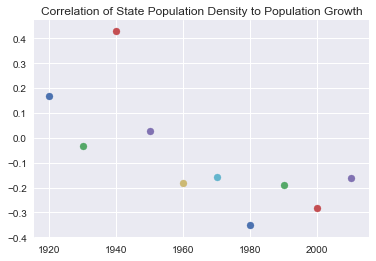

In [48]:
#Answering 2: How does population density one census affect the rate of population growth the next decade, if at all?


def corr_density_growth(initial_year): 
    density_key = str(initial_year) + '_DENSITY'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr = states_pop_density[density_key].corr(states_pop_change[growth_key], method='pearson')
    plt.scatter(initial_year + 10, corr)
    return corr
plt.title('Correlation of State Population Density to Population Growth')
density_growth_correlations = [corr_density_growth(1910 + (x * 10)) for x in range(10)]

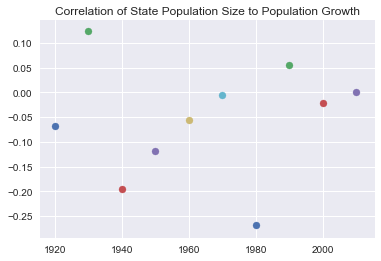

In [49]:
def corr_size_growth(initial_year): 
    size_key = str(initial_year) + '_POPULATION'
    growth_key = str(initial_year + 10) + '_CHANGE'
    corr = states_pop_change[size_key].corr(states_pop_change[growth_key], method='pearson')
    plt.scatter(initial_year + 10, corr)
    return corr

plt.title('Correlation of State Population Size to Population Growth')
size_growth_correlations = [corr_size_growth(1910 + (x * 10)) for x in range(10)]


It seems that population density of a state in one census is negatively correlated with its population growth in the next decade. However, these correlations are fairly weak. Interestingly, the decade 1930-1940 is a strong exception - in this decade, the two were positively correlated. I would conjecture this has to do with the Great Depression, during which there was a great migration westward in search of jobs (if my faint memory of history class is correct). States in the west were 

## Number of representatives per person
4. What are the best and worse states in terms of people per representative? 

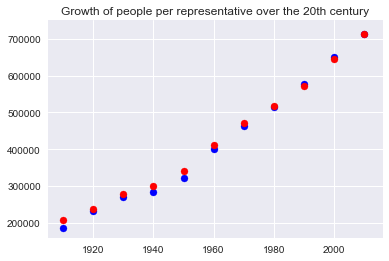

In [53]:
people_per_rep_2010 = apportionment_df['2010_PEOPLE_PER_REP']
pop_2010 = pop_density_df['2010_POPULATION']
#interesting. it seems like the states with shittiest representation are not the biggest but in fact the smallest

corr_popsize_people_per_rep = (pop_2010.corr(people_per_rep_2010, method='pearson'))

mean_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].mean())
std_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].std())
median_people_per_rep = values_for_all_years(lambda year: state_apportionment[str(year) + '_PEOPLE_PER_REP'].median())

for year in mean_people_per_rep.keys(): 
    plt.scatter(year, mean_people_per_rep[year], color='blue') #mean is blue
    plt.scatter(year, median_people_per_rep[year], color='red') #median is red 
plt.title('Growth of people per representative over the 20th century')
#so population has no correlation whatsoever with people per representative. 
#TODO: Data visualization here. X-axis can be size of population, and y-axis people per rep 
#TODO: Find out state trends in dilution of people per rep. 

## Apportionment

We have __ interesting findings:

First, the lopsided-ness of representation by state is at a historical peak. That is, the standard deviation in people per representative by states is at its peak in 2010. 

Second, as of 2010, there's no correlation whatsoever between population size and people per representative. This violates my initial intuition that big states have the worst ratio of representatives to population. In fact, the smallest states have it the worst. 

Some not so surprising trends are that: 

First, representation is getting diluted decade after decade as the population grows but the number of representatives has remained fixed. Mean and median representatives per person show a clear trend of growing per decade. 



## Fraction of population vs people per rep

Is it the case that the fraction of total population corresponds to the fraction of representatives you have in the House? Of course it does. This is a sanity check.

In [ ]:
'''This is buggy af. Logically the correlation should be close to if not exactly one. I initially intended
for this to just be a sanity check but now it appears I am in fact going insane.'''


#1. The total numbers of representatives are in fact correct. 
#2. If a state was not yet a state, its number of reps is zero. So, I can change these to NaNs and I don't think
#they'll get evaluated by the correlation function
#3. The population columns in pop_change_df include US and various regions. What we want is states pop change


#yes! this works!!! 


def corr_popfraction_repdensity(year): 
    zero_to_nan = lambda num: math.nan if (num == 0.0) else num 
    reps_with_nans = apportionment_df[str(year) + '_REPS'].apply(zero_to_nan)
    return states_pop_change[str(year) + '_POPULATION'].corr(reps_with_nans, method='pearson')

corr_values = values_for_all_years(corr_popfraction_repdensity)
print(corr_values)